In [2]:
import math, random, os, sys
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32

In [ ]:
# load MNIST
tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1)),  # flatten 28x28 → 784
    transforms.Lambda(lambda v: (v - v.mean()) / (v.std() + 1e-8))
])

mnist = datasets.MNIST(root="../data", train=True, download=True, transform=tfm)

def sample_digit(digit, device="cpu"):
    
    idxs = [i for i, (_, y) in enumerate(mnist) if y == digit]
    i = random.choice(idxs)     
    v, y = mnist[i]
    return v.view(-1).to(device)



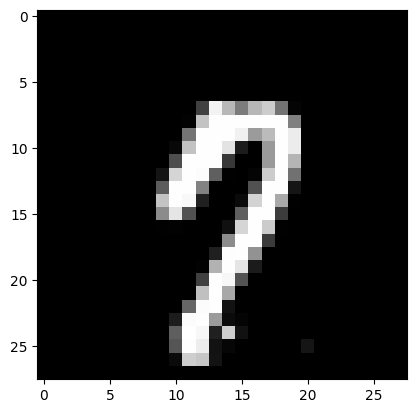

In [5]:
plt.imshow(sample_digit(7).view(28,28), cmap="gray")
plt.show()

In [6]:
# Constants
kBT = 1.0
mu = 1.0
J2 = 10.0
J4 = 10.0

# Chosen through trial and error
bias_scale = 15.0

Nv = 28*28  # number of visible units
Nh = 512     # number of hidden units

J_vh = torch.zeros(Nv, Nh, device=device)   # visible-to-hidden couplings
J_hh = torch.zeros(Nh, Nh, device=device)   # hidden-to-hidden couplings
b_h  = torch.zeros(Nh, device=device)       # hidden biases
# no visible-to-visible couplings

# Grad of energy function (autograd)
def energy_and_grad(x_v, x_h, b_v, b_h, J_vh, J_hh):
  
    b_v = b_v.to(x_v.device)
    b_h = b_h.to(x_h.device)
    
    # Compute V_theta(x) and its gradients (autograd)
    x_v = x_v.clone().detach().requires_grad_(True)
    x_h = x_h.clone().detach().requires_grad_(True)
    
    # Energy terms
    V = J2*(x_v.pow(2).sum() + x_h.pow(2).sum()) \
      + J4*(x_v.pow(4).sum() + x_h.pow(4).sum()) 
    V = V + (b_v @ x_v) + (b_h @ x_h) 
    V = V + (x_v @ J_vh @ x_h) + 0.5*(x_h @ J_hh @ x_h)
    
    V.backward()

    g_v = x_v.grad.detach()
    g_h = x_h.grad.detach()

    return V.item(), g_v, g_h

In [7]:
def euler_maruyama_step(x_v, x_h, b_v, b_h, J_vh, J_hh, dt, kBT=1.0, mu=1.0):
    
    # Compute energy and gradients
    V, g_v, g_h = energy_and_grad(x_v, x_h, b_v, b_h, J_vh, J_hh)
    
    # Gaussian noise
    noise_v = torch.randn_like(x_v)
    noise_h = torch.randn_like(x_h)
    
    sigma = torch.sqrt(torch.tensor(2.0 * mu * kBT * dt, device=x_v.device, dtype=x_v.dtype))

    # Euler-Maruyama update
    x_vn = x_v - mu * g_v * dt + sigma * noise_v
    x_hn = x_h - mu * g_h * dt + sigma * noise_h
    
    return  x_vn, x_hn, V


During the noising trajectory, biases fade linearly over time:
- Visible bias: $\mathbf{b}_v(t) = \alpha(t) \cdot \mathbf{P}$ (direct)
- Hidden bias: $\mathbf{b}_h(t) = \alpha(t) \cdot \mathbf{U} \mathbf{P}$ (projected)  
- Fade schedule: $\alpha(t) = \text{scale} \cdot (1 - t/T)$

In [ ]:
# Projection (Random Projection) 
# TODO: try alternatives
U = torch.randn(Nh, Nv, device=device) / math.sqrt(Nv)

def fade_schedule(k: int, K: int) -> float:
    return 1.0 - (k / K)

def visible_bias_schedule(P: torch.Tensor, k: int, K: int, scale=1.0) -> torch.Tensor:
    return (scale * fade_schedule(k, K) * P).to(P.device)

# Project visible bias onto hidden units
def hidden_bias_schedule(P: torch.Tensor, k: int, K: int, scale=1.0) -> torch.Tensor:
    return (scale * fade_schedule(k, K) * (U @ P)).to(P.device)

In [19]:
# Forward noising trajectory

def run_noising_trajectory(P, tf=2.5, dt=1e-3, snapshots=12, t_eq=0.5, use_trainable=False):
    
    K = int(tf / dt)
    snap_every = max(1, K // snapshots)
    
    if use_trainable:
        temp_J_vh, Jhh = J_vh, J_hh   # trainable parameters
    else:
        temp_J_vh = torch.zeros_like(J_vh)
        temp_J_hh = torch.zeros_like(J_hh)
    
    x_v = torch.randn(Nv, device=device)
    x_h = torch.randn(Nh, device=device)

    states_all = []
    vis_snaps = []
    
    # Reach equilibrium
    K_eq = int(t_eq / dt)
    for _ in range(K_eq):
        b_v = (P * bias_scale).to(P.device)
        b_h = ((U @ P) * bias_scale).to(P.device)    
        x_v, x_h, V = euler_maruyama_step(x_v, x_h, b_v, b_h, temp_J_vh, temp_J_hh, dt, kBT, mu)

    states_all.append((x_v.clone(), x_h.clone()))
    for k in range(K):
        b_v = visible_bias_schedule(P, k, K, scale=bias_scale)
        b_h = hidden_bias_schedule(P, k, K, scale=bias_scale)

        x_v, x_h, V = euler_maruyama_step(x_v, x_h, b_v, b_h, temp_J_vh, temp_J_hh, dt, kBT, mu)

        states_all.append((x_v.clone(), x_h.clone()))
        
        if k % snap_every == 0 or k == K - 1:
            vis_snaps.append(x_v.clone())

    return states_all, vis_snaps

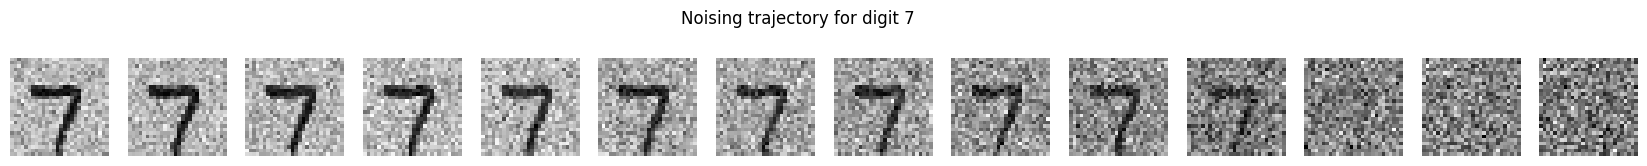

In [21]:
digit_id = 7
P = sample_digit(digit_id)

# Run forward noising trajectory
_, snaps = run_noising_trajectory(P, tf=2.5, dt=1e-3, snapshots=12)


plt.figure(figsize=(1.5*len(snaps), 2))
for i, state in enumerate(snaps):
    ax = plt.subplot(1, len(snaps), i+1)
    ax.imshow(state.view(28, 28).detach().cpu().numpy(), cmap="gray")
    ax.axis("off")
plt.suptitle(f"Noising trajectory for digit {digit_id}")
plt.show()

In [10]:
# Grad of energy function (analytic)
def grad_V_param(x_v, x_h, b_v, b_h, J_vh, J_hh, J2, J4):
    g_v = 2*J2*x_v + 4*J4*(x_v**3) + b_v + (J_vh @ x_h)
    g_h = 2*J2*x_h + 4*J4*(x_h**3) + b_h + (J_vh.T @ x_v) + (J_hh @ x_h)
    return g_v, g_h

In [25]:
def reverse_step_nll(
    x_v, x_h, x_v_next, x_h_next,
    J_vh, J_hh, b_h,
    dt, mu=1.0, kBT=1.0, J2=10.0, J4=10.0
):
    b_v0 = torch.zeros_like(x_v_next)

    g_vn, g_hn = grad_V_param(x_v_next, x_h_next, b_v0, b_h, J_vh, J_hh, J2, J4)

    dx_v = x_v_next - x_v
    dx_h = x_h_next - x_h

    r_v = -dx_v + mu * g_vn * dt
    r_h = -dx_h + mu * g_hn * dt

    denom = (4.0 * mu * kBT * dt)
    nll = (r_v.pow(2).sum() + r_h.pow(2).sum()) / denom

    return nll

In [106]:
def train_model(   
    digits = [0],                
    num_epochs=5,
    num_digits=1,
    dt_forward=1e-4,        
    dt_obj=5e-4,            
    tf_forward=0.5,
    lr=1e-3,
    clip_grad=1.0,
):
    # global lmao will change later
    global J_vh, J_hh, b_h, optimizer
    
    optimizer = torch.optim.Adam([J_vh, J_hh, b_h], lr=lr)
    
    losses = []
    
    for epoch in range(num_epochs):
        
        epoch_loss = 0.0 
        
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        per_digit = num_digits // len(digits)
        leftover = num_digits % len(digits)
        digit_list = digits * per_digit
        digit_list += random.sample(digits, leftover) 
        random.shuffle(digit_list) 
        #print(digit_list)
        
        for d in range(num_digits):
            
            digit_choice = digit_list[d]
            
            print(f"  Digit {d+1}/{num_digits}")
            
            
            P = sample_digit(digit_choice, device=device)
        
            
            # Forward noising trajectory (no trainable params)
            states_all, _ = run_noising_trajectory(
                P, tf=tf_forward, dt=dt_forward, use_trainable=False
            )
            
            num_steps = len(states_all) - 1
            
            total_loss = 0.0
            
            for step, ((x_v, x_h), (x_vn, x_hn)) in enumerate(
                zip(states_all[:-1], states_all[1:])
            ):
                
                nll = reverse_step_nll(
                    x_v, x_h, x_vn, x_hn,
                    J_vh, J_hh, b_h,
                    dt=dt_obj, mu=mu, kBT=kBT, J2=J2, J4=J4
                )
                total_loss += nll / num_steps
                
                if (step % max(1, num_steps // 5) == 0):
                    print(f"Step {step}/{num_steps}, NLL: {nll.item():.4f}")
                
            optimizer.zero_grad()
            total_loss.backward()
            if clip_grad is not None:
                torch.nn.utils.clip_grad_norm_([J_vh, J_hh, b_h], max_norm=clip_grad)
            optimizer.step()
            
            # Keep J_hh symmetric
            with torch.no_grad():
                J_hh.copy_(0.5 * (J_hh + J_hh.T))
                
            epoch_loss += total_loss.item()
                
        epoch_loss /= max(1, num_digits)
        losses.append(epoch_loss)
        
        normalized_loss = epoch_loss / (Nv + Nh)
        
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Normalized Loss: {normalized_loss:.4f}")
        
    return J_vh, J_hh, b_h, losses
             

In [ ]:
# Initialize trainable parameters (couplings and biases)
J_vh = nn.Parameter(torch.randn(Nv, Nh, device=device) * 0.01 / math.sqrt(Nv + Nh))
J_hh = nn.Parameter(torch.randn(Nh, Nh, device=device) * 0.01 / math.sqrt(Nh))
with torch.no_grad():
    J_hh.copy_(0.5 * (J_hh + J_hh.T))  # symmetric (why?)
b_h  = nn.Parameter(torch.zeros(Nh, device=device))

optimizer = torch.optim.Adam([J_vh, J_hh, b_h], lr=1e-3)

torch.manual_seed(42)

digits = [0, 1, 2]

J_vh, J_hh, b_h, losses = train_model(
    digits= digits,
    num_epochs=1,
    num_digits=3,  
    dt_forward=1e-4,
    dt_obj=5e-4,
    tf_forward=0.5,
    lr=1e-2,
    clip_grad=1.0,
)

Epoch 1/1
  Digit 1/3
Step 0/5000, NLL: 181.7618
Step 1000/5000, NLL: 163.3816
Step 2000/5000, NLL: 150.7842
Step 3000/5000, NLL: 148.9795
Step 4000/5000, NLL: 128.1196
  Digit 2/3
Step 0/5000, NLL: 170.6881
Step 1000/5000, NLL: 152.4782
Step 2000/5000, NLL: 149.6565
Step 3000/5000, NLL: 132.4227
Step 4000/5000, NLL: 135.2766
  Digit 3/3
Step 0/5000, NLL: 156.1894
Step 1000/5000, NLL: 155.7845
Step 2000/5000, NLL: 137.9434
Step 3000/5000, NLL: 137.2632
Step 4000/5000, NLL: 140.6851
Epoch 1, Loss: 146.3913, Normalized Loss: 0.1130


In [163]:
torch.save({
    "J_vh": J_vh,
    "J_hh": J_hh,
    "b_h": b_h,
    "losses": losses
}, "3digits_test.pth")

In [227]:
# Sample from trained model
def run_generation(J_vh, J_hh, b_h, tf=2.5, dt=1e-3, digit_bias=None, alpha=1.0, alpha_decay = 0.9, snapshots=12):
    
    K = int(tf / dt)
    snap_every = max(1, K // snapshots)

    x_v = torch.randn(Nv)
    x_h = torch.randn(Nh)

    vis_states = []

    for k in range(K):
        b_v = torch.zeros(Nv)  
        
        if digit_bias is not None:
            
            current_alpha = alpha * (alpha_decay ** (k / K))
            b_h_temp = b_h + current_alpha * digit_bias.to(b_h.device)
        else:
            b_h_temp = b_h
        

        x_v, x_h, V = euler_maruyama_step(
            x_v, x_h, b_v, b_h_temp, J_vh, J_hh, dt, kBT, mu
        )

        if k % snap_every == 0 or k == K - 1:
            vis_states.append(x_v.clone())

    return vis_states

In [1]:
def generate_from_checkpoint(pth_file="zero_test.pth", snapshots=12, tf=2.5, dt=1e-3, digit_bias = None, alpha = 1.0,  plot_loss_curve=True):
    
    if pth_file is None:
        J_vh = nn.Parameter(torch.randn(Nv, Nh, device=device) * 0.01 / math.sqrt(Nv + Nh))
        J_hh = nn.Parameter(torch.randn(Nh, Nh, device=device) * 0.01 / math.sqrt(Nh))
        with torch.no_grad():
            J_hh.copy_(0.5 * (J_hh + J_hh.T))  # symmetric (why?)
        b_h  = nn.Parameter(torch.zeros(Nh, device=device))
        
    else:
        checkpoint = torch.load(pth_file, map_location="cpu")
        J_vh = checkpoint["J_vh"]
        J_hh = checkpoint["J_hh"]
        b_h  = checkpoint["b_h"]
        losses = checkpoint["losses"]
    
    # Run generation
    samples = run_generation(J_vh, J_hh, b_h, tf=tf, dt=dt, digit_bias=digit_bias, alpha=alpha, snapshots=snapshots)

    # Plot
    plt.figure(figsize=(1.5 * len(samples), 2))
    for i, state in enumerate(samples):
        ax = plt.subplot(1, len(samples), i + 1)
        ax.imshow(state.view(28, 28).detach().cpu().numpy(), cmap="gray")
        ax.axis("off")
    plt.suptitle("Generated trajectory")
    plt.show()
    
    if plot_loss_curve:
   
        epochs = range(1, len(losses) + 1)
        plt.figure(figsize=(6, 4))
        plt.plot(epochs, losses, marker="o", label="Training Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Training Loss Curve")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    


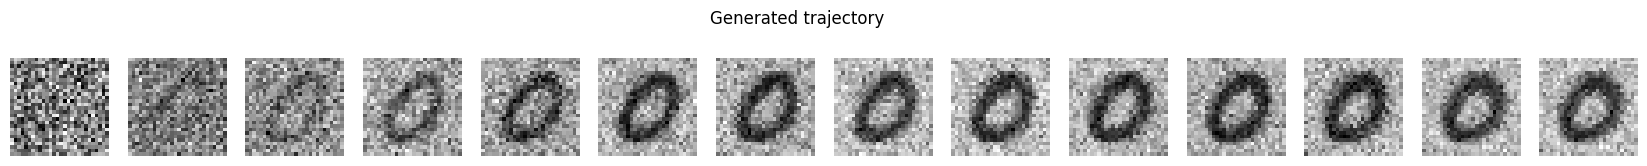

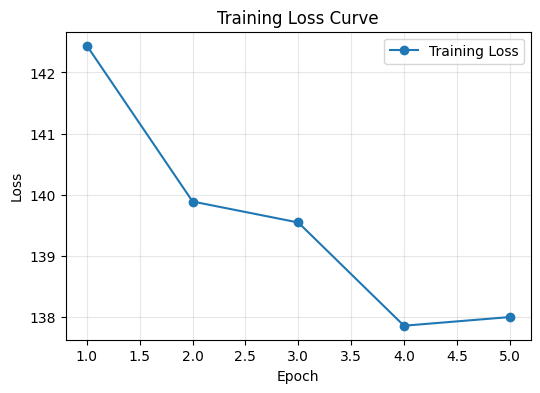

In [306]:
# Trained on zero digit only

generate_from_checkpoint("checkpoints/zero_test.pth", snapshots=12, tf=1, dt=1e-3, plot_loss_curve=True)

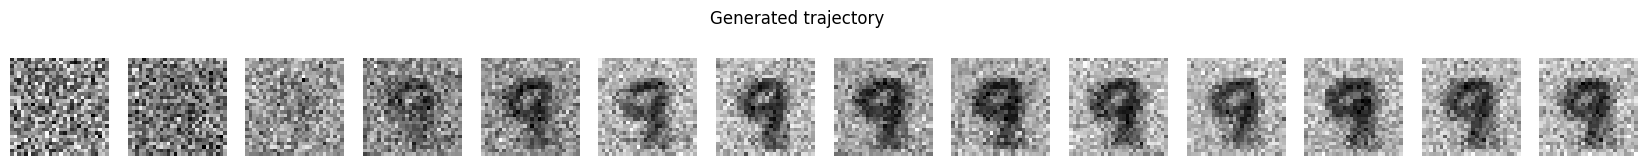

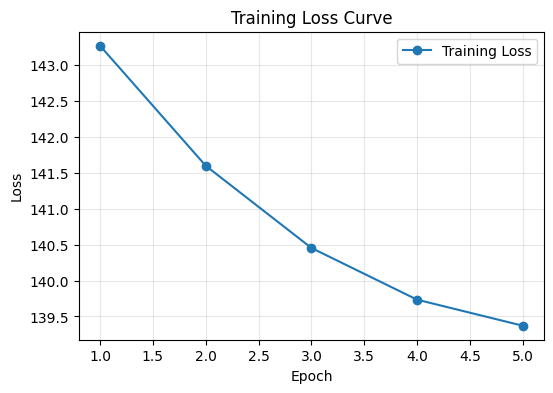

In [309]:
# Trained on nine digit only

generate_from_checkpoint("checkpoints/nine_test.pth", snapshots=12, tf=1, dt=1e-3, alpha = 1.0, plot_loss_curve=True)

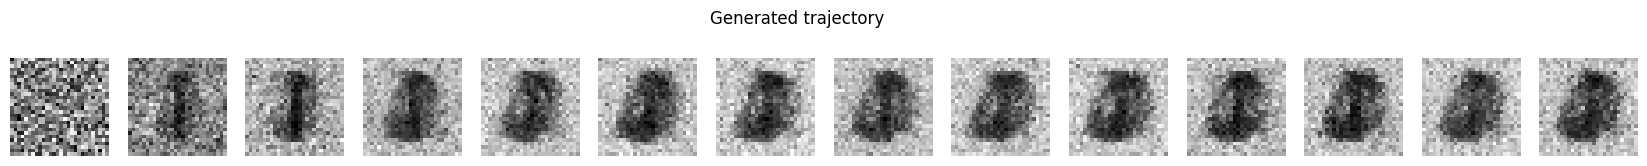

In [310]:

generate_from_checkpoint("checkpoints/3digits_test.pth", snapshots=12, tf=2.5, dt=1e-3, plot_loss_curve=False)

When trained on multiple digits, to generate a specific digit, the generation  
has to be guided. This is done by adding an extra hidden bias during sampling:

$$
b_h = b_h + \alpha \, U P_d
$$

where  

- $P_d$: template for digit $d$  
- $U$: projection to hidden space  
- $\alpha$: guidance strength  


In [177]:
def create_digit_template(digit, mnist, num_samples=50, device="cpu"):

    samples = []
    idxs = [i for i, (_, y) in enumerate(mnist) if y == digit]
    
    selected_idxs = random.sample(idxs, min(num_samples, len(idxs)))
    for idx in selected_idxs:
        v, _ = mnist[idx]
        samples.append(v.view(-1))
    
    template = torch.stack(samples).mean(dim=0).to(device)
    return template



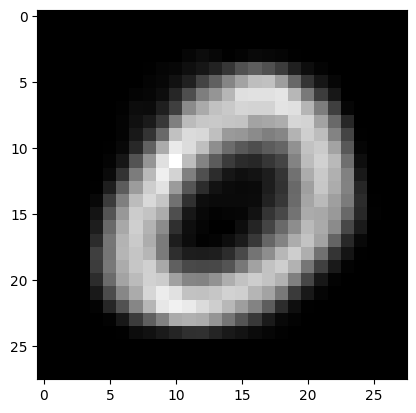

In [261]:
template_0 = create_digit_template(0, mnist, num_samples=50, device=device)
template_1 = create_digit_template(1, mnist, num_samples=50, device=device)
template_2 = create_digit_template(2, mnist, num_samples=50, device=device)
template_3 = create_digit_template(3, mnist, num_samples=50, device=device)
plt.imshow(template_0.view(28,28).cpu().numpy(), cmap="gray")

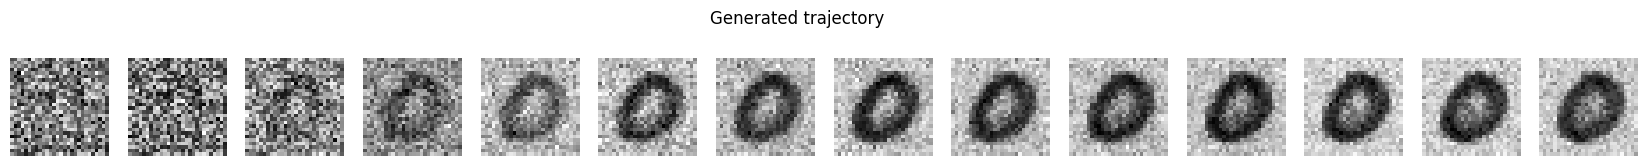

In [311]:
# 0
hidden_bias = (U @ template_0).to(device)

generate_from_checkpoint(
    "checkpoints/3digits_test.pth", 
    snapshots=12, 
    tf=0.2, 
    dt=1e-3, 
    digit_bias=hidden_bias,  
    alpha=20.0,  
    plot_loss_curve=False
)

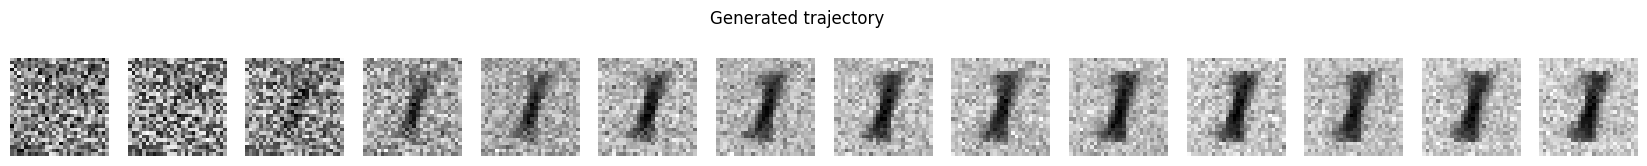

In [312]:
# 1
hidden_bias = (U @ template_1).to(device)

generate_from_checkpoint(
    "checkpoints/3digits_test.pth", 
    snapshots=12, 
    tf=0.2, 
    dt=1e-3, 
    digit_bias=hidden_bias,  
    alpha=20.0,  
    plot_loss_curve=False
)

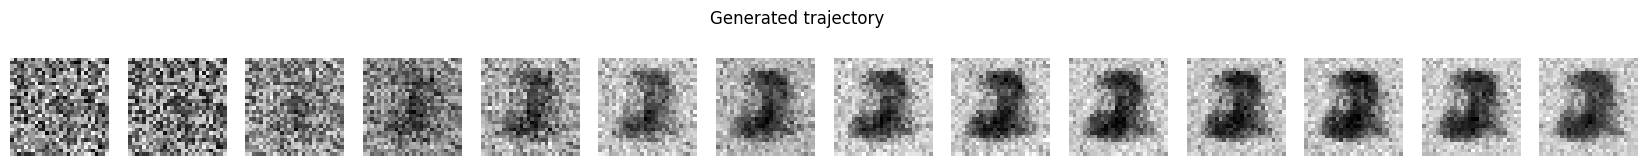

In [313]:
# 2
hidden_bias = (U @ template_2).to(device)

generate_from_checkpoint(
    "checkpoints/3digits_test.pth", 
    snapshots=12, 
    tf=0.2, 
    dt=1e-3, 
    digit_bias=hidden_bias,  
    alpha=20.0,  
    plot_loss_curve=False
)

In [ ]:
hidden_bias = (U @ template_2).to(device)

generate_from_checkpoint(
    None, 
    snapshots=12, 
    tf=0.2, 
    dt=1e-3, 
    digit_bias=hidden_bias,  
    alpha=20.0,  
    plot_loss_curve=False
)